In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import time
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch using ', device.type)

pytorch using  cuda


In [72]:
# hyperparameter

max_words = 300
sentence_len = 20
pred_len = 1  # fix
train_len = sentence_len - pred_len

epochs = 20
batch_size = 2**9

max_samples = int(4e5) #6e6 max


In [73]:
# pre trained word embeddings

import bcolz

glove_path = './'
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

embedding_dim = 50

# if files do not exist run glove_embedding.ipynb first

In [74]:

def build_vocab(words, max_words=None):
    if max_words is None:
        return list(set(words))
    
    vocab = {}
    for word in word_seq:
        try:
            vocab[word] += 1
        except KeyError:
            vocab[word] = 1
    most_freq = sorted(vocab.keys(), key=vocab.get, reverse=True)
    return most_freq[:max_words]


def replace_by_tbl(text, tbl):
    for k,v in tbl.items():
        text = text.replace(k,v)
    return text


# preprossing mapping tables
apostrophe_tbl = {ord(key): '\'' for key in '\`\´\’'}
shortform_tbl = {
    'n\'t' : ' not',
    '\'ve' : ' have',
    '\'ll' : ' will',
    '\'m' : ' am',
    '\'re' : ' are',
    '\'s' : ' is',
    '\'d' : ' would',
}
remove_apostrophe_tbl = {ord('\''): None}
restore_oclock = {'oclock': 'o\'clock'}


def preprocess_text(text):
    text = text.translate(apostrophe_tbl)       # uniform apostrophe
    text = replace_by_tbl(text, shortform_tbl)  # split shortforms
    text = text.translate(remove_apostrophe_tbl)  # remove rest of '
    text = replace_by_tbl(text, restore_oclock)   # restore o'clock
    return text


def text2words(text, vocab_set):
    words = text_to_word_sequence(preprocess_text(text))
    return [ word for word in words if word in word2idx and word in vocab_set]

In [75]:

with open('processed_texts.csv', 'r', encoding='UTF-8') as file:
    texts = [line.strip('\n') for line in file]

word_seq = []
for text in texts:
    text = preprocess_text(text)
    words_in_text = text_to_word_sequence(text)
    word_seq += words_in_text

# remove all words that have no embedding
word_seq = [ word for word in word_seq if word in word2idx]

vocab = build_vocab(word_seq, max_words)
vocab_size = len(vocab)
print(f'size of vocablary: {vocab_size}')

# remove all words that are not in the vocabulary
vocab_set = set(vocab)
word_seq = [ word for word in word_seq if word in vocab_set]

# tokenized sequence of words
w2tk = {}
for i, word in enumerate(vocab):
    w2tk[word] = i

tkn_seq = [w2tk[word] for word in word_seq]
tkn_seq = np.array(tkn_seq)

size of vocablary: 300


the tokens of the words are acquired by the index of the vocabulary and not the words2idx function.

The reason for that is to minimize the range of tokens. 

Therefore we could use a function to easily map the tokens to the embeddings. 

This direct mapping is btw. only possible because we filter all unknown words for GloVe in our training data

In [76]:
def tk2emb(token):
    return glove[vocab[token]]

In [77]:
# Sliding window to generate train data
seq = []
for i in range(len(tkn_seq)-sentence_len):
    seq.append(tkn_seq[i:i+sentence_len])

# reduce length of seq for performance reasons and of cause test_set
print('available samples: ', len(seq))
seq = seq[:max_samples]

# set data, label
X = []
y = []
for i in seq:
    X.append(i[:train_len])
    y.append(i[-1])

num_samples = len(y)

X = np.array(X)
y = np.array(y)

print('training samples: ', num_samples)

MemoryError: 

In [78]:

# split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=.5)

# setting type for device
X_type = torch.cuda.LongTensor if device.type == 'cuda' else torch.LongTensor
y_type = torch.cuda.LongTensor if device.type == 'cuda' else torch.LongTensor

# create feature and targets tensor for train set.
torch_X_train = torch.from_numpy(X_train).type(X_type)
torch_y_train = torch.from_numpy(y_train).type(y_type)

# create feature and targets tensor for valid set.
torch_X_valid = torch.from_numpy(X_valid).type(X_type)
torch_y_valid = torch.from_numpy(y_valid).type(y_type)

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(X_type)
torch_y_test = torch.from_numpy(y_test).type(y_type)

# Pytorch train and valid sets
train = torch.utils.data.TensorDataset(torch_X_train, torch_y_train)
valid = torch.utils.data.TensorDataset(torch_X_valid, torch_y_valid)
test = torch.utils.data.TensorDataset(torch_X_test, torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)


print('train batches:    ', len(train_loader))
print('validate batches: ', len(valid_loader))
print('test batches:     ', len(valid_loader))

MemoryError: Unable to allocate 17.4 MiB for an array with shape (240000, 19) and data type int32

In [79]:
def save_torch_model(model):
    dt_str = ''.join(['_'+str(t) for t in time.localtime(time.time())[:4]])
    path = './models/' + model.__class__.__name__ + dt_str + '.pth'
    torch.save(model, path)


def train(model, criterion, optimizer, data_loader):
    model.train()
    correct = 0
    losses = 0
    num_batches = len(data_loader) 
    
    for X_batch, y_batch in data_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()

        losses += loss.item()
        predicted = torch.max(pred.data, 1)[1]  # maxout
        correct += (predicted == y_batch).sum()
    
    # average loss and accuracies per epoch
    loss = losses / float(num_batches)
    accu = correct / float(batch_size * num_batches)
    
    return loss, accu.cpu()


def test(model, criterion, data_loader):
    model.eval()
    correct = 0
    losses = 0
    num_batches = len(data_loader) 

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            loss = criterion(pred, y_batch)

            losses += loss.item()
            predicted = torch.max(pred.data, 1)[1]  # maxout
            correct += (predicted == y_batch).sum()
    
    # average loss and accuracies per epoch
    loss = losses  / float(num_batches)
    accu = correct / float(batch_size * num_batches)
    
    return loss, accu.cpu()


def fit(model, train_loader, valid_loader, test_loader, optimizer, criterion, scheduler=None, save_model=False):
    print("fitting model...")
    
    train_eval = []
    valid_eval = []
    fit_start = time.time()

    #iteration 0 (only testing initial model)
    train_loss, train_accu = test(model, criterion, train_loader)
    train_eval.append( (train_loss, train_accu) )
    valid_loss, valid_accu = test(model, criterion, valid_loader)
    valid_eval.append( (valid_loss, valid_accu) )
    print('Epoch: 0')
    print('Train:        Loss: {:.6f}   Accuracy: {:.2f}%  '.format(train_loss, train_accu * 100))
    print('Validation:   Loss: {:.6f}   Accuracy: {:.2f}%\n'.format(valid_loss , valid_accu * 100))

    for epoch in range(epochs):
        epoch_start = time.time()

        train_loss, train_accu = train(model, criterion, optimizer, train_loader)
        train_eval.append( (train_loss, train_accu) )
        
        valid_loss, valid_accu = test(model, criterion, valid_loader)
        valid_eval.append( (valid_loss, valid_accu) )

        if(scheduler != None): scheduler.step()  # update learning rate

        print('Epoch: {},    duration: {:.2f}sec'.format(epoch + 1, time.time() - epoch_start))
        print('Train:        Loss: {:.6f}   Accuracy: {:.2f}%  '.format(train_loss, train_accu * 100))
        print('Validation:   Loss: {:.6f}   Accuracy: {:.2f}%\n'.format(valid_loss , valid_accu * 100))

    d = time.gmtime(time.time() - fit_start)
    print('duration of fitting: {:2d}h {:2d}min {:2d}sec\n'.format(d.tm_hour, d.tm_min, d.tm_sec))

    # save model
    if save_model:
        save_torch_model(model)

    # final evaluation
    test_loss, test_accu = test(model, criterion, test_loader)
    print('evaluation on test-set:')
    print(f'Test:   Loss: {test_loss:.6f}   Accuracy: {test_accu * 100:.2f}%\n')

    return np.array(train_eval), np.array(valid_eval)


def plot_eval(train_eval, valid_eval):

    train_losses = train_eval[:, 0]
    train_accus  = train_eval[:, 1]
    valid_losses = valid_eval[:, 0]
    valid_accus  = valid_eval[:, 1]
    min_loss_idx = np.argmin(valid_losses)
    max_accu_idx = np.argmax(valid_accus)

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(train_losses, label="train")
    plt.plot(valid_losses, label="validation")
    plt.scatter(min_loss_idx, valid_losses[min_loss_idx], c='r', label="minimum")
    plt.title("evaluation of losses")
    plt.xlabel("epochs")
    plt.legend()
    plt.subplot(122)
    plt.plot(train_accus, label="train")
    plt.plot(valid_accus, label="validation")
    plt.scatter(max_accu_idx, valid_accus[max_accu_idx], c='r', label="maximum")
    plt.title("evaluation of accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()


def save_eval_data(model, train_eval, valid_eval):
    data = np.array([train_eval, valid_eval])
    path = './models/evalutation_' + model.__class__.__name__
    numpy.savetxt(path, data, delimiter=",")

In [80]:
# create the predefined embedding layer

matrix_len = vocab_size

weights_matrix = np.zeros((matrix_len, embedding_dim))
words_found = 0

for i, word in enumerate(vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

num_embeddings, embedding_dim = weights_matrix.shape
emb_layer = nn.Embedding(num_embeddings, embedding_dim)
emb_layer.load_state_dict({ 'weight': torch.tensor(weights_matrix) })
emb_layer.weight.requires_grad = False  # non trainable if False
emb_layer.to(device)
emb_layer

Embedding(300, 50)

In [81]:
learning_rate = 0.08
m1_lstm_hidden = 100
m1_dense_features = 100
m1_dropout = 0.3

class Model1(nn.Module):
    
    def __init__(self):
        super(Model1, self).__init__()
        self.rnn = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=m1_lstm_hidden, 
                            num_layers=2)
        self.dense1 = nn.Linear(in_features=m1_lstm_hidden, 
                                out_features=m1_dense_features)
        self.dense2 = nn.Linear(in_features=m1_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = emb_layer(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-1,:]  
        x = F.relu( self.dense1(x) )
        #x = F.dropout(x, p=m1_dropout)
        x = F.relu( self.dense2(x) )
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


Model1()

Model1(
  (rnn): LSTM(50, 100, num_layers=2)
  (dense1): Linear(in_features=100, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=300, bias=True)
)

In [82]:
# ebedding loss - loss based on distance of embedding

class myLoss(nn.Module):

    def __init__(self, embed):
        super(myLoss, self).__init__()
        self.embed = embed
        self.weight_mat = embed.weight.view(-1,vocab_size, embedding_dim)

    def forward(self, output, target):

        # outputs are positive therefore dividing by sum of outputs is distribution
        output = output / output.sum(dim=1).view(-1,1).repeat(1,output.size()[1])

        bsz = output.size()[0]
        weight_mat = self.weight_mat.repeat(bsz,1,1)
        emb_target = self.embed(target.view(-1,1).repeat(1, vocab_size))
        
        # weighted squared SME or precicely SSE (weighted by outputs)
        loss = ( output * ((weight_mat - emb_target)**2).sum(dim=2) ).sum()
        return loss


In [83]:

# model2 = Model1().to(device)
# eval_train2, eval_valid2 = fit(model=model2, 
#                                train_loader=train_loader, 
#                                valid_loader=valid_loader, 
#                                test_loader=test_loader, 
#                                optimizer=optim.Adam(model2.parameters(), lr=learning_rate), 
#                                criterion=myLoss(emb_layer).to(device), 
#                                save_model=False)
# plot_eval(eval_train2, eval_valid2)

fitting model...
Epoch: 0
Train:        Loss: 5.710239   Accuracy: 0.09%  
Validation:   Loss: 5.710213   Accuracy: 0.10%

Epoch: 1,    duration: 22.07sec
Train:        Loss: 5.710224   Accuracy: 0.08%  
Validation:   Loss: 5.710160   Accuracy: 0.08%

Epoch: 2,    duration: 22.20sec
Train:        Loss: 5.710235   Accuracy: 0.08%  
Validation:   Loss: 5.710083   Accuracy: 0.08%

Epoch: 3,    duration: 22.63sec
Train:        Loss: 5.710253   Accuracy: 0.08%  
Validation:   Loss: 5.710136   Accuracy: 0.08%

Epoch: 4,    duration: 22.66sec
Train:        Loss: 5.710235   Accuracy: 0.08%  
Validation:   Loss: 5.710195   Accuracy: 0.09%

Epoch: 5,    duration: 22.18sec
Train:        Loss: 5.710244   Accuracy: 0.08%  
Validation:   Loss: 5.710161   Accuracy: 0.08%

Epoch: 6,    duration: 21.85sec
Train:        Loss: 5.710238   Accuracy: 0.08%  
Validation:   Loss: 5.710141   Accuracy: 0.08%

Epoch: 7,    duration: 21.79sec
Train:        Loss: 5.710249   Accuracy: 0.08%  
Validation:   Loss: 5.

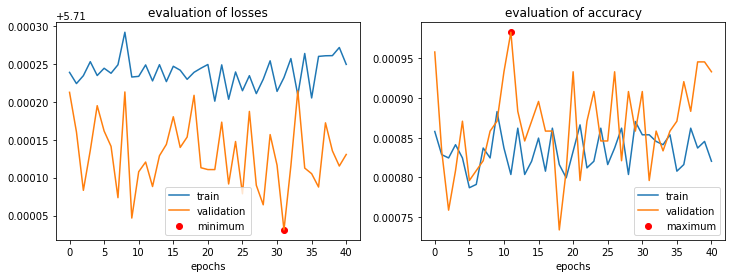

In [60]:
model1 = Model1().to(device)
eval_train1, eval_valid1 = fit(model=model1, 
                               train_loader=train_loader, 
                               valid_loader=valid_loader,
                               test_loader=test_loader, 
                               optimizer=optim.Adam(model1.parameters(), lr=learning_rate), 
                               criterion=nn.CrossEntropyLoss().to(device), 
                               save_model=False)
plot_eval(eval_train1, eval_valid1)

In [61]:
def gen(model, sentence, iterations=10):

    seq = [w2tk[word] for word in text2words(sentence, vocab_set)]
    #if(len(seq) < train_len): return -1
    
    for i in range(iterations):
        iput = np.array(seq[-19:])
        iput = np.vstack(iput).T
        iput = torch.from_numpy(iput).type(X_type)

        # oput = F.log_softmax( model(iput) )  # prob dist
        oput = model(iput)
        
        oput = oput.cpu().detach().numpy()[0]
        oput = np.argmax(oput) # max of softmax to long
        seq.append(oput)

    pred_sen = ''
    for tk in seq:
        pred_sen += vocab[tk] + ' '
    return pred_sen

In [68]:
sen = "Good evening today i will talk about something of high importance. I hope you will enjoy hearing about"
print(gen(model1, sen))
# print(gen(model2, sen))

good today i will talk about something of high i you will about bit bit bit looking bit bit bit bit bit see 
